In [2]:
import pandas as pd

# Preprocessing

In [3]:
# Constants
normal_cohort_csv_path = "../../../normal_cohort_echo_reports.csv"
preprocessed_normal_cohort_csv_path = "../../preprocessed_normal_cohort_echo_reports.csv"

In [4]:
# load the csv
preprocessed_normal_cohort = pd.read_csv(normal_cohort_csv_path)


## Count Patients

In [5]:
normal_cohort = pd.read_csv(normal_cohort_csv_path)
n_unique_patients = normal_cohort["Pat_ResearchID"].nunique()
n_unique_patients

4023

Print all variables.

In [6]:
normal_cohort.columns

Index(['Pat_ResearchID', 'Fall_ResearchID', 'echokardiographie_dttm',
       'Datum_Echokardiographie', 'Uhrzeit_Echokardiographie',
       'Groesse_Echokardiographie', 'Gewicht_Echokardiographie', 'BMI',
       'Echoqualitaet', 'Mitralklappe', 'Aortenklappe', 'Aorta',
       'Trikuspidalklappe', 'Pulmonalklappe', 'VenaCavaInferior',
       'RechterVorhof', 'RechterVentrikel', 'LinkerVorhof', 'ESD_M_Mode',
       'LinkerVentrikel', 'ESV', 'EDV', 'EF', 'Ebene',
       'RegionaleWandbewegungen', 'Septum', 'Hinterwand', 'EDD', 'LVMMI',
       'rTh', 'LV_Fuellung', 'HeartFrequency', 'BloodPressure_Systole',
       'BloodPressure_Diastole'],
      dtype='object')

## Drop unnecessary columns
Like time, date and ids.

In [7]:
preprocessed_normal_cohort = preprocessed_normal_cohort.drop(columns=[
    'Pat_ResearchID',
    'Fall_ResearchID',
    'echokardiographie_dttm',
    'Datum_Echokardiographie',
    'Uhrzeit_Echokardiographie']
)

## Zero values for a lot of numerical variables

Looking at below histograms we see that some varibles exhibit a two peak distribution where one looks like a gaussian curve and the other is a spike at 0. Including:
 - Septum (width)
 - Hinterwand (width)
 - EDD
 - (LVMMI might be hidden by a few very high values)
 - rTh
 - LV_Fuellung

array([[<AxesSubplot:title={'center':'Groesse'}>,
        <AxesSubplot:title={'center':'Gewicht'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'ESD_M_Mode'}>],
       [<AxesSubplot:title={'center':'ESV'}>,
        <AxesSubplot:title={'center':'EDV'}>,
        <AxesSubplot:title={'center':'EF'}>,
        <AxesSubplot:title={'center':'Septum'}>],
       [<AxesSubplot:title={'center':'Hinterwand'}>,
        <AxesSubplot:title={'center':'EDD'}>,
        <AxesSubplot:title={'center':'LVMMI'}>,
        <AxesSubplot:title={'center':'rTh'}>],
       [<AxesSubplot:title={'center':'LV_Fuellung'}>,
        <AxesSubplot:title={'center':'HeartFrequency'}>,
        <AxesSubplot:title={'center':'BloodPressure_Systole'}>,
        <AxesSubplot:title={'center':'BloodPressure_Diastole'}>]],
      dtype=object)

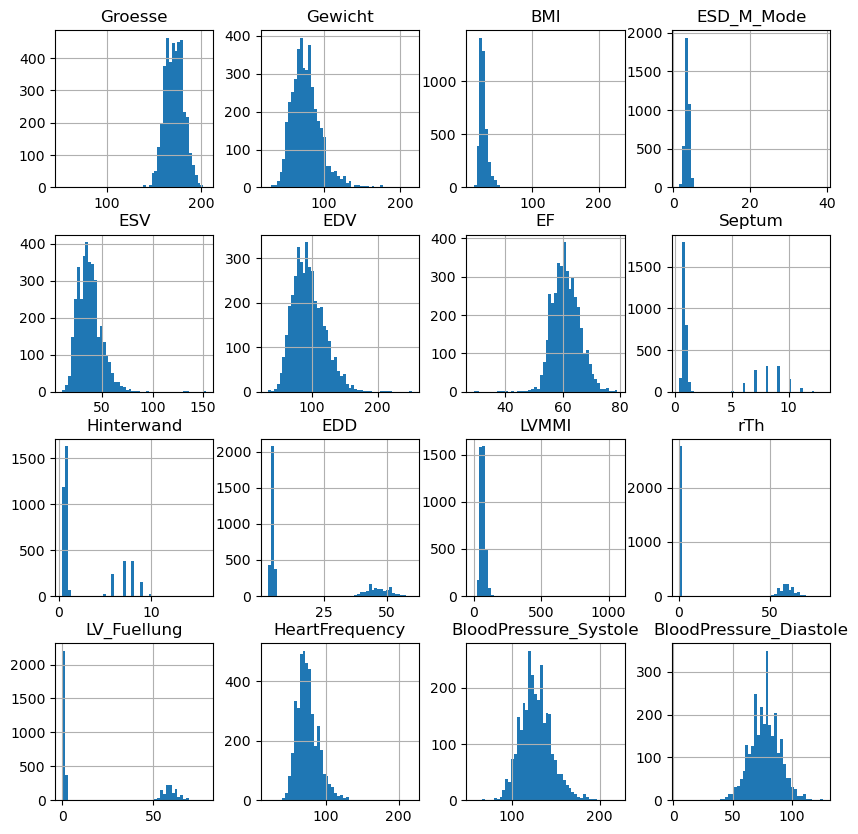

In [9]:
preprocessed_normal_cohort.rename({"Groesse_Echokardiographie": "Groesse", "Gewicht_Echokardiographie": "Gewicht"}, axis=1).hist(bins=50, figsize=(10,10))

After looking at the csv it seems that some entries are in cm and others in mm. To check that I partition the normal cohort using (one of) the variables above and plot the two distributions.

Septum mean: Septum    0.882808
dtype: float64
Septum mean: Septum    8.237977
dtype: float64
Hinterwand mean: Hinterwand    0.782648
dtype: float64
Hinterwand mean: Hinterwand    7.402651
dtype: float64
EDD mean: EDD    4.676022
dtype: float64
EDD mean: EDD    46.44942
dtype: float64
LVMMI mean: LVMMI    67.798121
dtype: float64
LVMMI mean: LVMMI    635.0
dtype: float64
rTh mean: rTh    0.33695
dtype: float64
rTh mean: rTh    59.498325
dtype: float64
LV_Fuellung mean: LV_Fuellung    0.294072
dtype: float64
LV_Fuellung mean: LV_Fuellung    59.498325
dtype: float64
ESD_M_Mode mean: ESD_M_Mode    3.491052
dtype: float64
ESD_M_Mode mean: ESD_M_Mode    32.5
dtype: float64


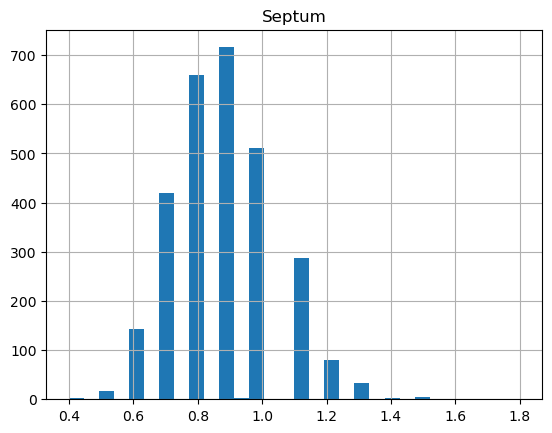

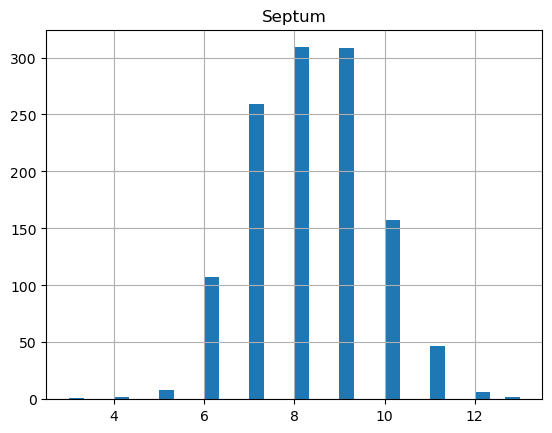

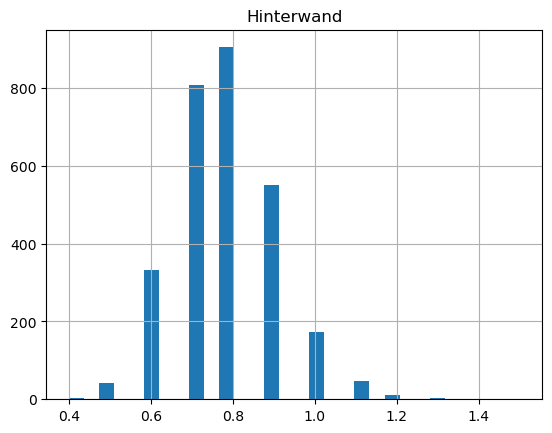

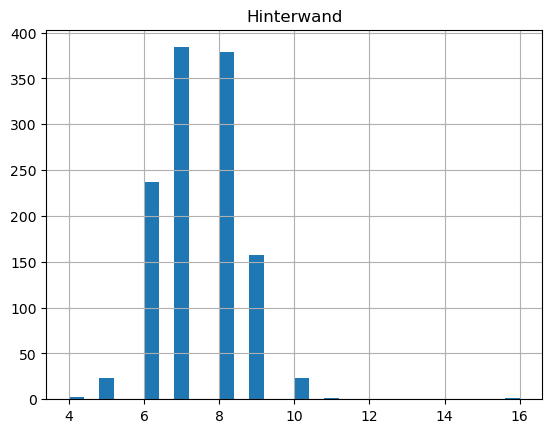

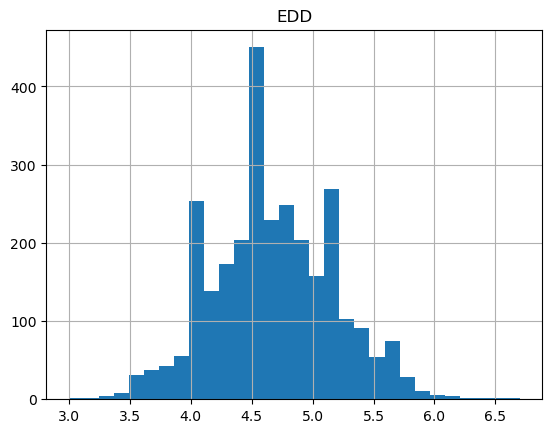

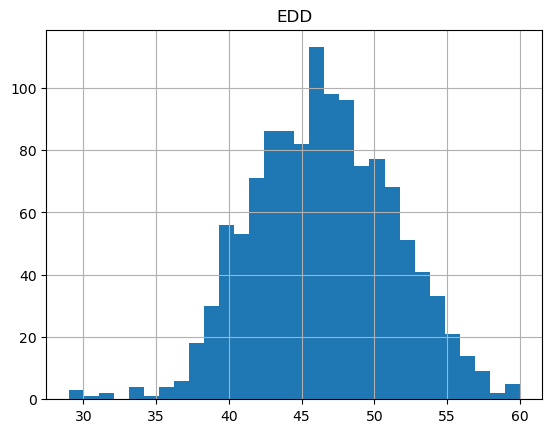

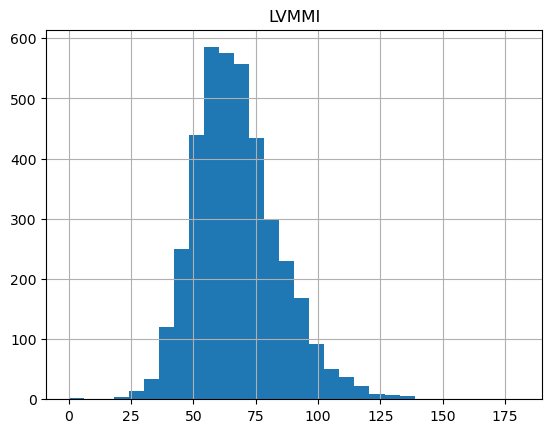

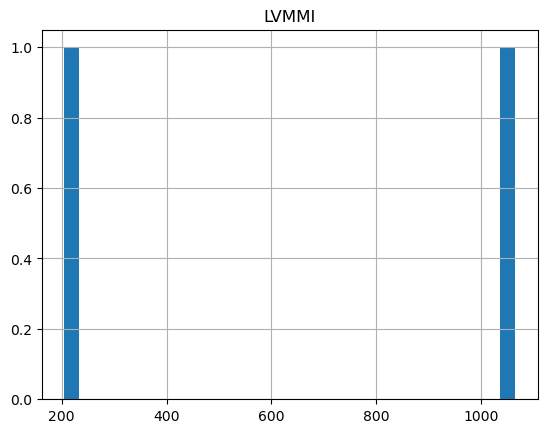

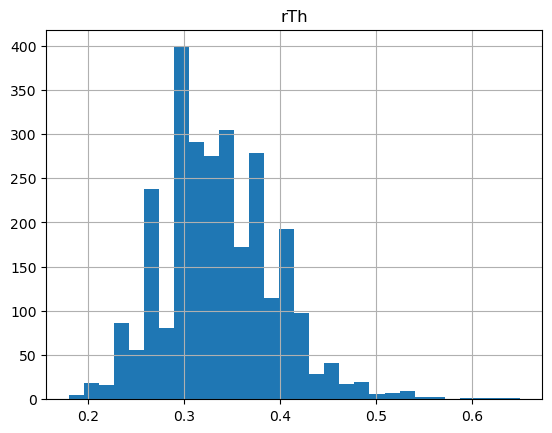

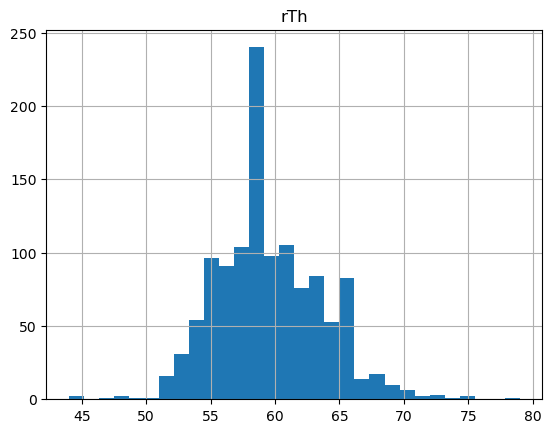

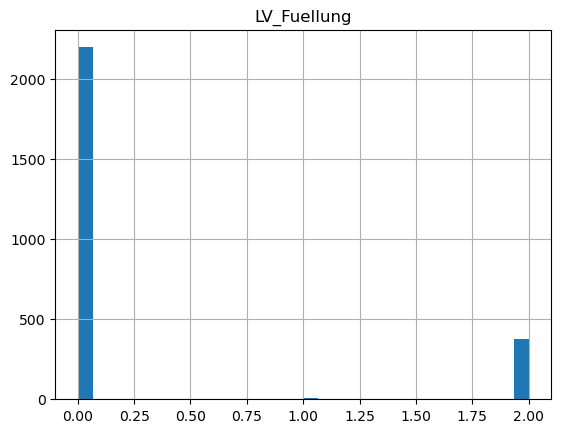

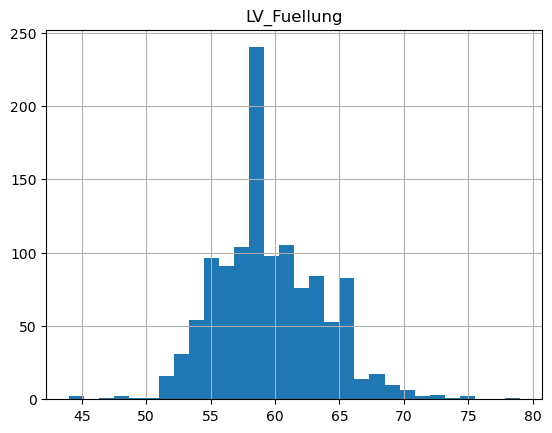

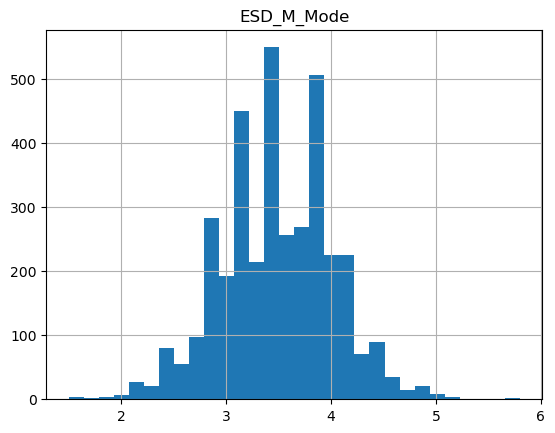

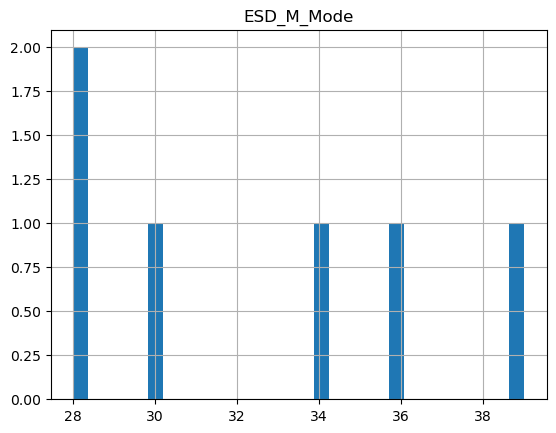

In [10]:
variables = [
    'Septum',
    'Hinterwand',
    'EDD',
    'LVMMI',
    'rTh',
    'LV_Fuellung',
    'ESD_M_Mode'
]
partition_values = [
    2,
    2,
    10,
    200,
    10,
    10,
    10
]

for i,variable in enumerate(variables):
    series = preprocessed_normal_cohort[[variable]]
    series_mm = series[series < partition_values[i]]
    series_cm = series[series > partition_values[i]]

    series_mm.hist(bins=30)
    print('{} mean: {}'.format(variable, series_mm.mean()))
    series_cm.hist(bins=30)
    print('{} mean: {}'.format(variable, series_cm.mean()))



Looking at the distributions we see that for Septum, Hinterwand, EDD and ESD_M_Mode the mm/cm hypothesis confirmed. The peaks are just scaled by 10.

For LVMMI we see that there are just two outliers.

For LV_Fuellung there is something weird going on. We get a normal distribution with peak at 60 but over 2000 entries are 0 and nearly 500 entries have value 2.

For rTh we also see two normal distribution where but it's got a scale different from 10.

So we add preprocessing:
 - rescale cm Septum, Hinterwand and EDD values to mm
 - rescale rTh values below 10 by 176.57 (see cell above)
 - set the LV_Fuellung values to null where it is 0 or 2
 - remove rows that contian the two LVMMI outliers


In [11]:
# scale

preprocessing_functions = [
    {
        'v': 'Septum',
        'f': lambda x: x * 10 if x < 2 else x
    },{
        'v': 'Hinterwand',
        'f': lambda x: x * 10 if x < 2 else x
    },{
        'v': 'EDD',
        'f': lambda x: x * 10 if x < 10 else x
    },{
        'v': 'ESD_M_Mode',
        'f': lambda x: x * 10 if x < 10 else x
    },{
        'v': 'rTh',
        'f': lambda x: x * 176.57 if x < 10 else x
    },{
        'v': 'LV_Fuellung',
        'f': lambda x: None if (x == 0 or x == 1 or x == 2) else x
    }
]


for preprocessing_function in preprocessing_functions:

    variable = preprocessing_function['v']
    preprocessed_normal_cohort[variable] = preprocessed_normal_cohort[variable].map(preprocessing_function['f'])


# remove
preprocessed_normal_cohort = preprocessed_normal_cohort[preprocessed_normal_cohort['LVMMI'] != 1065]
preprocessed_normal_cohort = preprocessed_normal_cohort[preprocessed_normal_cohort['LVMMI'] != 205]

preprocessed_normal_cohort.to_csv(preprocessed_normal_cohort_csv_path)

array([[<AxesSubplot:title={'center':'Groesse_Echokardiographie'}>,
        <AxesSubplot:title={'center':'Gewicht_Echokardiographie'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'ESD_M_Mode'}>],
       [<AxesSubplot:title={'center':'ESV'}>,
        <AxesSubplot:title={'center':'EDV'}>,
        <AxesSubplot:title={'center':'EF'}>,
        <AxesSubplot:title={'center':'Septum'}>],
       [<AxesSubplot:title={'center':'Hinterwand'}>,
        <AxesSubplot:title={'center':'EDD'}>,
        <AxesSubplot:title={'center':'LVMMI'}>,
        <AxesSubplot:title={'center':'rTh'}>],
       [<AxesSubplot:title={'center':'LV_Fuellung'}>,
        <AxesSubplot:title={'center':'HeartFrequency'}>,
        <AxesSubplot:title={'center':'BloodPressure_Systole'}>,
        <AxesSubplot:title={'center':'BloodPressure_Diastole'}>]],
      dtype=object)

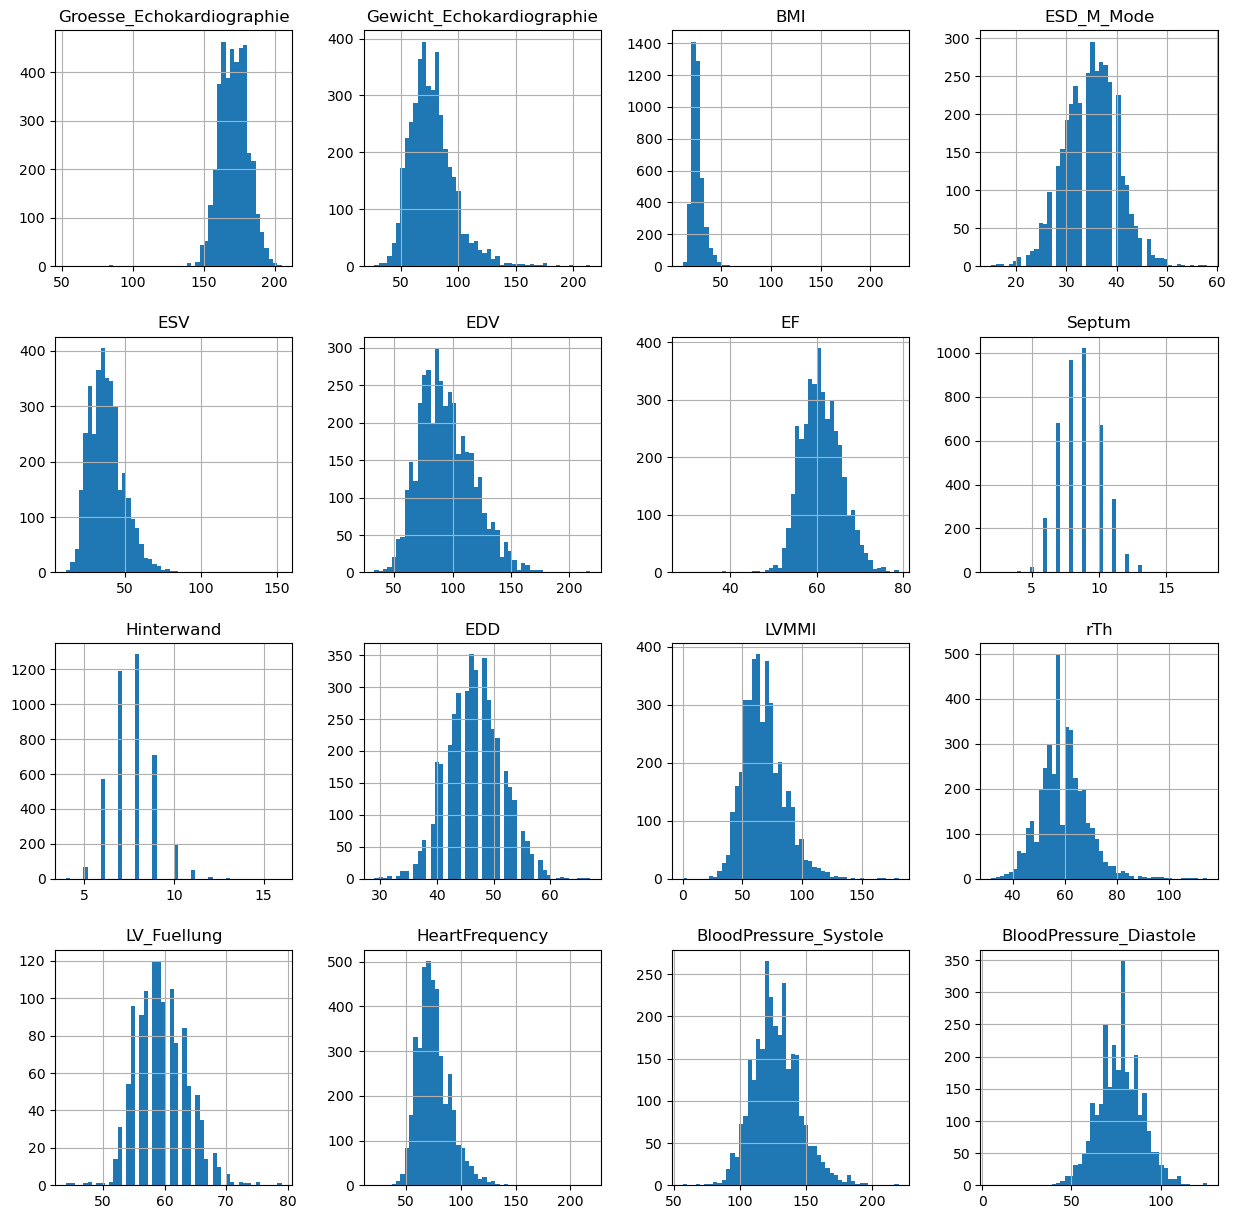

In [15]:
preprocessed_normal_cohort.hist(bins=50, figsize=(15,15))

## Strings
We should also check the string columns:

array([<AxesSubplot:title={'center':'Echoqualitaet'}>,
       <AxesSubplot:title={'center':'Mitralklappe'}>,
       <AxesSubplot:title={'center':'Aortenklappe'}>,
       <AxesSubplot:title={'center':'Aorta'}>,
       <AxesSubplot:title={'center':'Trikuspidalklappe'}>,
       <AxesSubplot:title={'center':'Pulmonalklappe'}>,
       <AxesSubplot:title={'center':'VenaCavaInferior'}>,
       <AxesSubplot:title={'center':'RechterVorhof'}>,
       <AxesSubplot:title={'center':'RechterVentrikel'}>,
       <AxesSubplot:title={'center':'LinkerVorhof'}>,
       <AxesSubplot:title={'center':'LinkerVentrikel'}>,
       <AxesSubplot:title={'center':'Ebene'}>,
       <AxesSubplot:title={'center':'RegionaleWandbewegungen'}>],
      dtype=object)

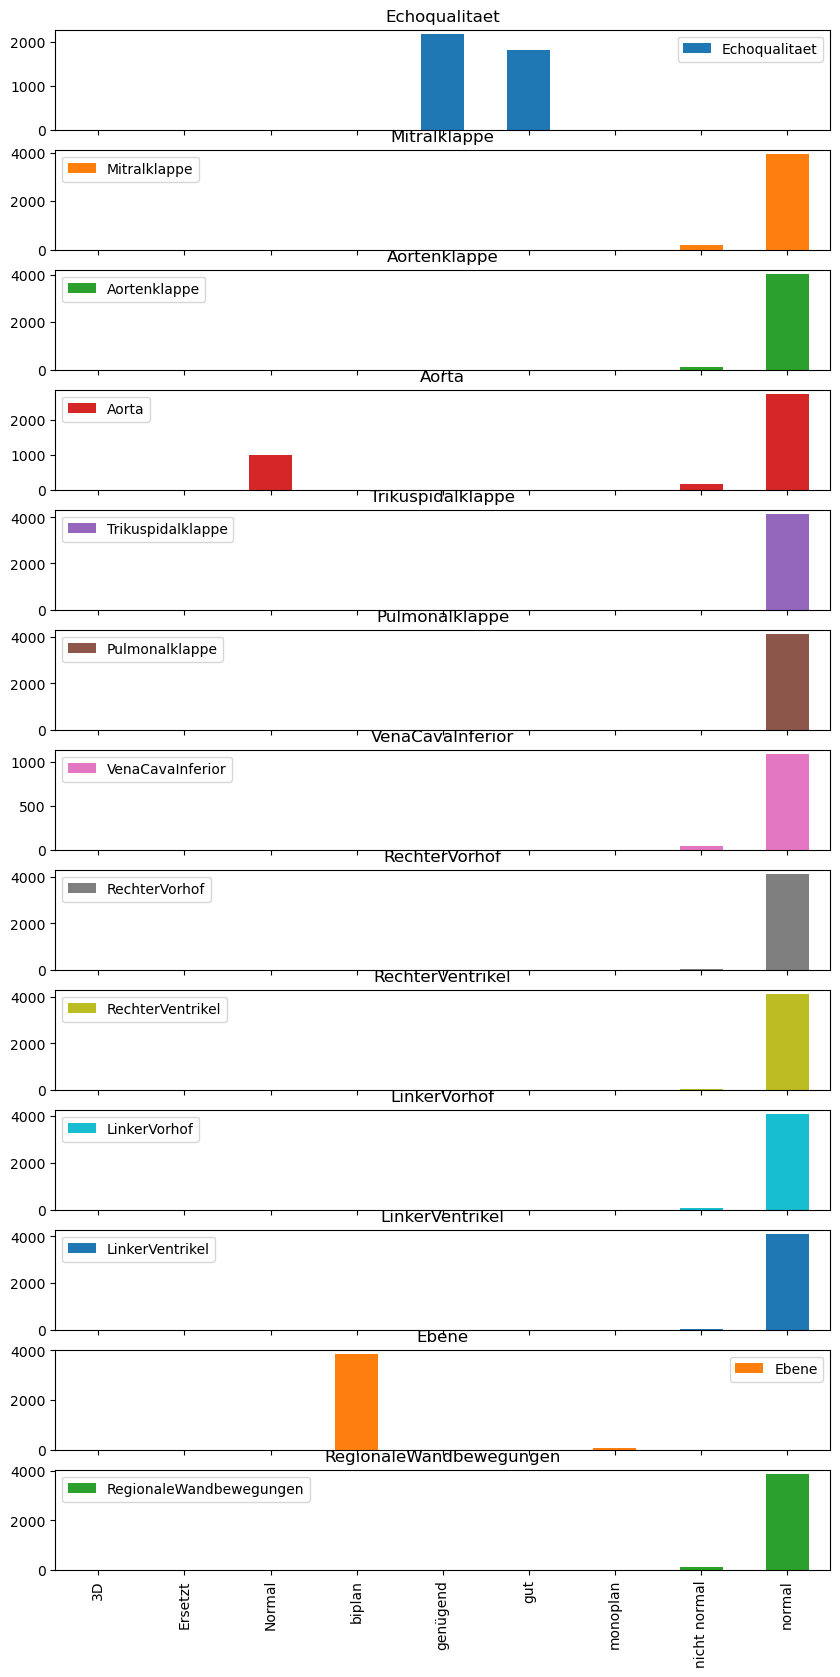

In [16]:
strings_normal_cohort = preprocessed_normal_cohort.select_dtypes(['object']).copy()
strings_normal_cohort.apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(10, 20))


We see that there exists "Normal" and "normal" which is not good. So we just map all "normal" to "Normal".

In [31]:
# rename
rename = lambda x: "normal" if x == "Normal" else x
preprocessed_normal_cohort['Aorta'] = preprocessed_normal_cohort['Aorta'].apply(rename)

preprocessed_normal_cohort.to_csv(preprocessed_normal_cohort_csv_path)


array([<AxesSubplot:title={'center':'Echoqualitaet'}>,
       <AxesSubplot:title={'center':'Mitralklappe'}>,
       <AxesSubplot:title={'center':'Aortenklappe'}>,
       <AxesSubplot:title={'center':'Aorta'}>,
       <AxesSubplot:title={'center':'Trikuspidalklappe'}>,
       <AxesSubplot:title={'center':'Pulmonalklappe'}>,
       <AxesSubplot:title={'center':'VenaCavaInferior'}>,
       <AxesSubplot:title={'center':'RechterVorhof'}>,
       <AxesSubplot:title={'center':'RechterVentrikel'}>,
       <AxesSubplot:title={'center':'LinkerVorhof'}>,
       <AxesSubplot:title={'center':'LinkerVentrikel'}>,
       <AxesSubplot:title={'center':'Ebene'}>,
       <AxesSubplot:title={'center':'RegionaleWandbewegungen'}>],
      dtype=object)

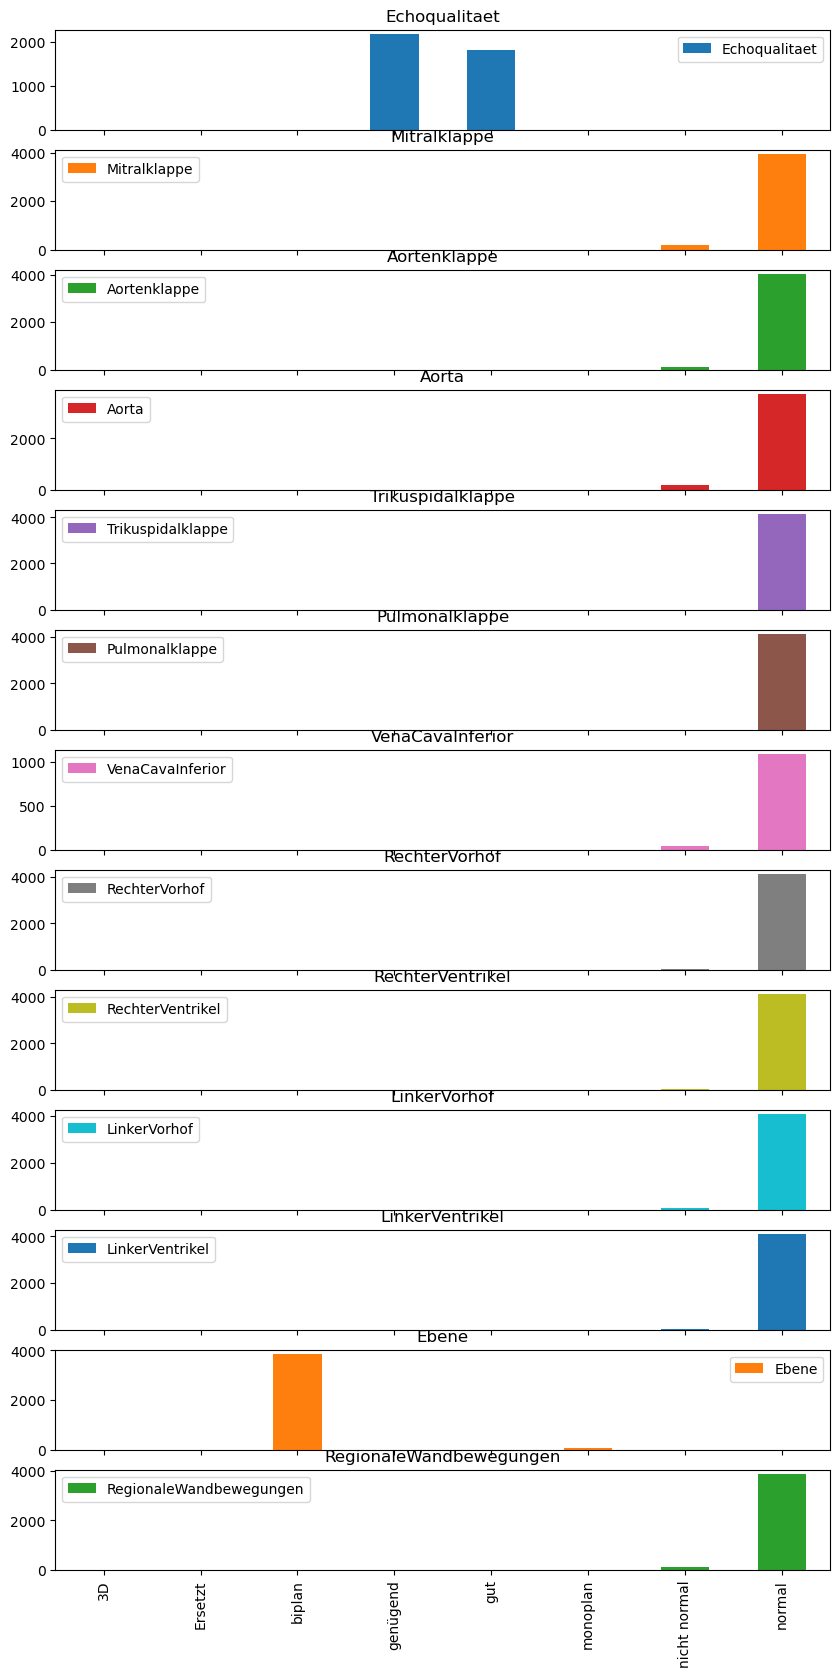

In [19]:
# check if worked
test_preprocessed_normal_cohort = preprocessed_normal_cohort.select_dtypes('object').copy()

test_preprocessed_normal_cohort.apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(10, 20))

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0


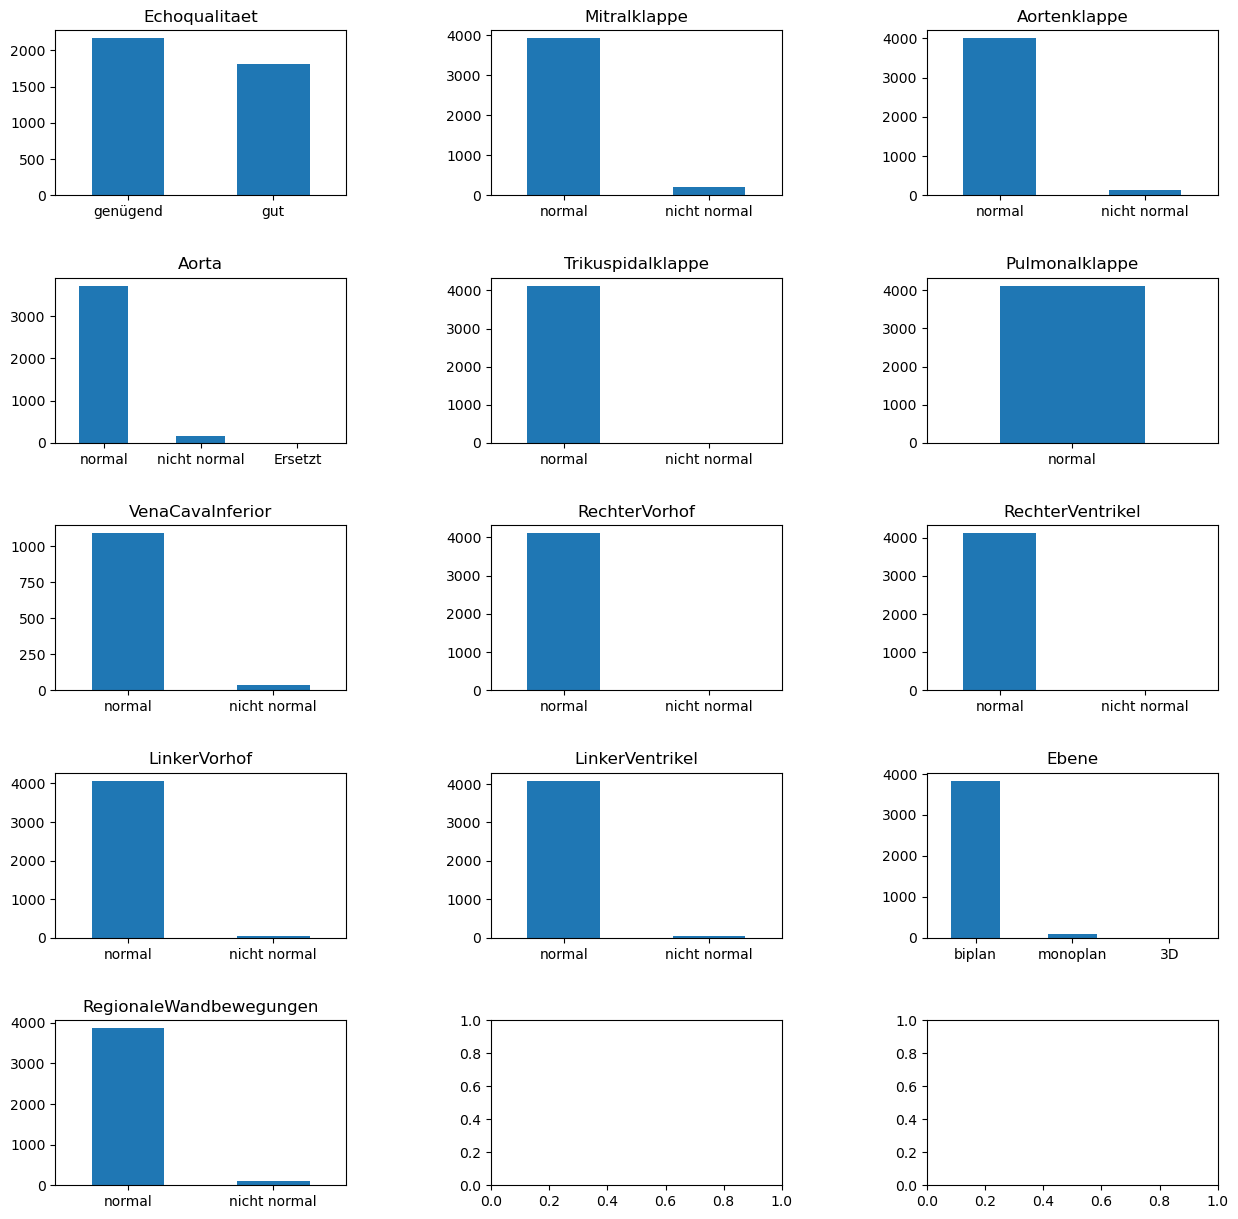

In [32]:

# plot bar chart for each string column in a single plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 3, figsize=(15,15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, column in enumerate(preprocessed_normal_cohort.select_dtypes('object').columns):
    row = i // 3
    col = i % 3
    print(row, col)
    v_counts = preprocessed_normal_cohort[column].value_counts()
    preprocessed_normal_cohort[column].value_counts().plot(kind='bar', ax=ax[row, col], rot=0)
    ax[row, col].set_title(column)

plt.show()